# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework 10
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, April 13th, 2018 at 10:59am

**Instructions:**

- Upload your final answers as an iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem #1: Iris Eyes Are Smiling

This Homework problem is a continuation of Problem #4 from Homework 8.  We'll be using the same iris dataset. The iris data can be obtained [here](./iris.csv).

Now that we have from Homework 8 Problem #4 a train-test split as well as point estimate(s) and a posterior distribution on the probability of a data point being virginica, we can use these to make predictions on both the training set and test set.

** *Note this next section is just guidance and doesn't contain any work for you to do* **

*There are two ways to make these predictions, given an estimate of $p(y=1\ \vert\ x)$:* 

(A) You can sample from the Bernoulli likelihood at the data point $x$ to decide if that particular data points classification $y(x)$ should be a 1 or a 0.

(B) Or you could do the intuitive "machine-learning-decision-theoretic" (MLDT) thing, where you assign a data  point $x$ a classification 1 if $p(y=1 \vert x) > 0.5$.

*There are multiple ways in which you can do these probability estimates at a sample $x$:*

(A) You can just use a point estimate like the MAP value, ($p_{MAP}$), or the posterior mean ($p_{MEAN}$)

(B) You can see what fraction of your posterior samples have values above 0.5 (ie you are calculating 1-cdf(0.5)) on the posterior ($p_{CDF}$))

Both these above methods miss the combined smearing of the posterior and sampling distributions. In other words they dont sample from the posterior predictive. If we draw a large number of samples from the posterior predictive distribution at a data point $x$, the fraction of 1s will give an estimate for the probability to use, $p_{PP}$, which is different from the MAP estimate, or the CDF estimate.

** *Note this next section contains the tasks we expect you to complete* **


1. Plot the distribution of $p_{MEAN}$, $p_{CDF}$, and $p_{PP}$ over all the data points in the training set. How are these different?
2. Plot the posterior-predictive distribution of the misclassification rate with respect to the true class identities $y(x)$ of the data points $x$ (in other words you are plotting a histogram with the misclassification rate for the $n_{trace}$ posterior-predictive samples) on the training set.
3. Make the same plot from the posterior, rather than the posterior predictive, by using the MLDT defined above. Overlay this plot on the previous one. That is, for every posterior sample, consider whether the data point ought to be classified as a 1 or 0 from the $p>0.5 \implies y=1$ decision theoretic prespective. Compare with your previous diagram. Which case (from posterior-predictive or from-posterior) has a wider mis-classification distribution? 
4. Is the classification at the true training data points (you can think of this as a bitstring '100101...' 90 characters long) represented in the posterior predictive trace? If so, how many times? Is it the most frequent string in the traces? Explain your conclusions.
5. Repeat 2 and 3 for the test set, i.e. make predictions. Describe and interpret the widths of the distributions?


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
df = pd.read_csv('iris.csv')
df['class'] = (df['class'] == ' Iris-virginica')*1
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,0:4], df.iloc[:,4], test_size=0.4, random_state=42,stratify=df.iloc[:,4])
X_train['intercept'] = 1
X_test['intercept']= 1
from pymc3 import Normal, Bernoulli, sample, Model # Import relevant distributions
from pymc3.math import invlogit
from theano import shared

xshared = shared(X_train.values)

with Model() as iris:

    beta = pm.Normal('beta', 0, sd=10,shape=5)
    
    # Calculate probabilities of death
    pvals = pm.Deterministic('pvals',var=pm.math.sigmoid( pm.math.dot(beta,xshared.T)))

    # Data likelihood
    flower_type = pm.Bernoulli('flower_type', p=pvals, observed=y_train.values)
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta]


#### Question 1

In [104]:
#to obtain pCDF
newtrace = trace['pvals']

In [105]:
newtrace[newtrace>0.5] = 1
newtrace[newtrace<0.5] = 0 

In [106]:
#to obtain pp
ppc_samples = pm.sample_ppc(trace,samples=500,model = iris)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1377.30it/s]


In [107]:
ppc_samples['flower_type'].shape

(500, 90)

C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


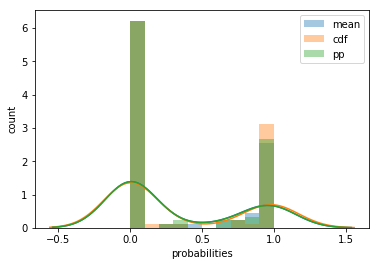

In [108]:
plt.figure()
sns.distplot(np.mean(trace['pvals'],axis=0),label='mean',bins=10)
sns.distplot(np.sum(newtrace,axis=0)/newtrace.shape[0],label='cdf',bins=10)
sns.distplot(np.sum(ppc_samples['flower_type'],axis=0)/ppc_samples['flower_type'].shape[0],label='pp',bins=10)
plt.xlabel('probabilities')
plt.ylabel('count')
plt.legend()

The mean distribution has the most spread and the CDF has very little. The posterior predictive lies at the intersection of the two.

#### Question 2

C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'count')

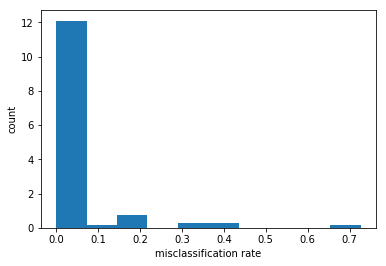

In [109]:
plt.hist(np.sum(np.abs(ppc_samples['flower_type']-y_train.values),axis=0)/ppc_samples['flower_type'].shape[0],normed=True);

plt.xlabel('misclassification rate')
plt.ylabel('count')

#### Question 3

C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'count')

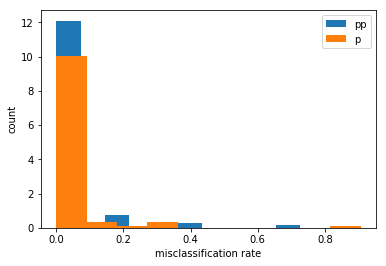

In [110]:
plt.hist(np.sum(np.abs(ppc_samples['flower_type']-y_train.values),axis=0)/ppc_samples['flower_type'].shape[0],normed=True,bins=10,label='pp');
plt.hist(np.sum(np.abs(newtrace-y_train.values),axis=0)/newtrace.shape[0],normed=True,bins=10,label='p');
plt.legend()
plt.xlabel('misclassification rate')
plt.ylabel('count')

The posterior has a wider misclassification distribution since the probability variances are much higher when considering the posterior over the posterior predictive.

#### Question 4

In [111]:
print('number of times true y appears = %s' %(np.sum(np.sum(ppc_samples['flower_type']-y_train.values,axis=1) == 0)/500))

number of times true y appears = 0.202


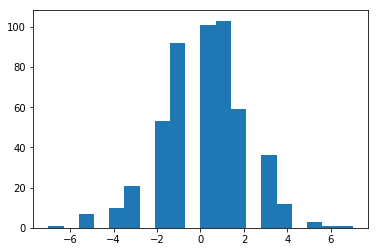

In [114]:
plt.hist(np.sum(ppc_samples['flower_type']-y_train.values,axis=1),bins=20);

I get that this string of true values is represented in our data approximately 22$\%$ of the time and it is indeed the most frequent string in our posterior predictive when I run many samples! If the posterior predictive is good, the mean should be comparable to the true data. 

#### Question 5`

C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'count')

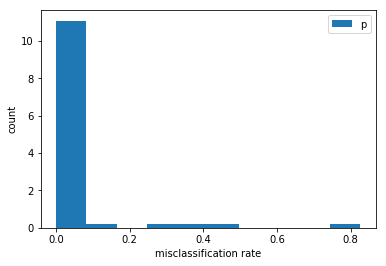

In [115]:
import math

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
#find posteriors at x_test values
post_test = sigmoid( np.dot(trace['beta'],X_test.values.T))
newtrace = post_test
newtrace[newtrace>0.5] = 1
newtrace[newtrace<0.5] = 0  
plt.hist(np.sum(np.abs(newtrace-y_test.values),axis=0)/newtrace.shape[0],normed=True,bins=10,label='p');
plt.legend()
plt.xlabel('misclassification rate')
plt.ylabel('count')

In [116]:
xshared.set_value(X_test.values)
ppc_samples = pm.sample_ppc(trace,samples=500,model = iris)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1419.28it/s]


C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'count')

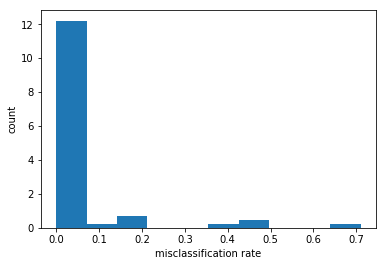

In [117]:
plt.hist(np.sum(np.abs(ppc_samples['flower_type']-y_test.values),axis=0)/ppc_samples['flower_type'].shape[0],normed=True);
plt.xlabel('misclassification rate')
plt.ylabel('count')

C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'count')

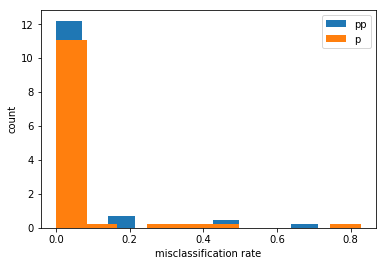

In [118]:
plt.hist(np.sum(np.abs(ppc_samples['flower_type']-y_test.values),axis=0)/ppc_samples['flower_type'].shape[0],normed=True,bins=10,label='pp');
plt.hist(np.sum(np.abs(newtrace-y_test.values),axis=0)/newtrace.shape[0],normed=True,bins=10,label='p');
plt.legend()
plt.xlabel('misclassification rate')
plt.ylabel('count')

Note that while the posterior is wider than the posterior predictive (just as it was on the training set), the test points cause the misclassification rate to be even wider. This is because there is uncertainty associated with data at the test points and so the results make sense: test points should have a wider misclassification width than train points.

## Problem 2: From the Ritz to the Rubble

In this problem, much like in Long Homework 9, you will explore how to recast data, tasks and research questions from a variety of different contexts so that an existing model can be applied for analysis.

Example 10.1.3 in "Statistical Rethinking", the excerpt of which is included in the data directory for this assignment, illustrates a study of the effect of an applicant's gender on graduate school admissions to six U.C. Berkeley departments through a comparison of four models. 

In this problem, you are given the data for the 1994 U.S. Census. The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)). You will be investigate the effect of gender on a person's yearly income in the dataset. In particular, we want to know how a person's gender effect the likelihood of their yearly salary being above or below \$50k. 

First we want to aggregate the dataset by seven different categories. The categories we wish to consider are: 
- 4 year college degree
- Some-college or two year academic college degree
- High school
- Professional, vocational school
- Masters 
- Doctorate
- Some or no high school
Note that you might have to combine some of the existing education categories in your dataframe. For each category, we suggest that you only keep track of a count of the number of males and females who make above (and resp. below) $50k (see the dataset in Example 10.1.3). 

Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above \$50k and 0 being below), one of these models should include the effect of gender while the other should not. 

Replicate the analysis in 10.1.3 using your models; specifically, compute= wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. Using your analysis, discuss the effect of gender on income.

Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. 

Replicate the analysis in 10.1.3 using your models; specifically, compute AIC/BIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data. Using your analysis, discuss the effect of gender on income, taking into account an individual's education.

In [3]:
df = pd.read_csv('census_data.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
g = df.groupby('edu')

g.groups.keys()

dict_keys(['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'])

Within the categories of interest the following apply:
    
4 year college degree : {Bachelors}

Some-college/2year program: {Assoc-acdm,Assoc-voc,Some-college}

High School : {HS-grad}

Professional School : {Prof-school}

Masters : {Masters}

Doctorate : {Doctorate}

Some or no HS: {10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,'Preschool'}

In [5]:
maindf = pd.DataFrame(columns=['group','gender','above 50','below 50', 'total'])

In [6]:
# get groups
groups = [['Bachelors'],['Assoc-acdm','Assoc-voc','Some-college'],['HS-grad'],['Prof-school'],['Masters'],['Doctorate'],['10th','11th','12th','1st-4th','5th-6th','7th-8th','9th','Preschool']]
sexes = ['Male','Female']
for i in range(len(groups)):
    for j in range(len(sexes)):
        bfifty = df.loc[df['edu'].isin(groups[i])&(df['sex']==sexes[j])&(df['earning']=='<=50K')]
        afifty = df.loc[df['edu'].isin(groups[i])&(df['sex']==sexes[j])&(df['earning']=='>50K')]
        maindf.loc[len(maindf)] = [str(i),sexes[j],len(afifty),len(bfifty),len(afifty)+len(bfifty)]

In [7]:
maindf

,group,gender,above 50,below 50,total
0,0,Male,1882,1854,3736
1,0,Female,339,1280,1619
2,1,Male,1693,4320,6013
3,1,Female,320,3407,3727
4,2,Male,1449,5662,7111
5,2,Female,226,3164,3390
6,3,Male,381,103,484
7,3,Female,42,50,92
8,4,Male,780,407,1187
9,4,Female,179,357,536


In [8]:
mi = (maindf['gender'] == 'Male')*1

In [9]:
mi.values

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [11]:
with pm.Model() as gender:
    alpha = pm.Normal("alpha", 0, 10)
    betam = pm.Normal("betam", 0, 10)
    logitpi = alpha + betam*mi.values
    gen = pm.Binomial("gen", p=pm.math.invlogit(logitpi),n=maindf['total'].values.tolist(),observed=maindf['above 50'].values)
    gentrace = pm.sample(5000)

with pm.Model() as nogender:
    alpha = pm.Normal("alpha", 0, 10)
    betam = pm.Normal("betam", 0, 10)
    logitpi = alpha 
    nogen = pm.Binomial("nogen", p=pm.math.invlogit(logitpi),n=maindf['total'].values.tolist(),observed=maindf['above 50'].values)
    nogentrace = pm.sample(5000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betam, alpha]
The acceptance probability does not match the target. It is 0.9086862700635205, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chain

In [12]:
def make_compare(names, traces, models, ic='WAIC'):
    comparedf=pm.compare(traces,models, method='pseudo-BMA')
    temp=comparedf.sort_index()
    temp['Model']=names
    comparedf = temp.sort_values(ic).set_index('Model')
    return comparedf

In [13]:
names=['gender', 'nogender']
dfc=make_compare(names, [gentrace,nogentrace],[gender,nogender])
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
gender,4946.77,482.76,0,1,1190.08,0,1
nogender,6492.71,411.49,1545.94,0,1600.42,1397.89,1


In [16]:
ppcgen = pm.sample_ppc(gentrace,500,model=gender)
ppcnogen = pm.sample_ppc(nogentrace,500,model=nogender)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 3519.56it/s]


Text(0.5,1,'Posterior Predictive Check: Gender Included Model')

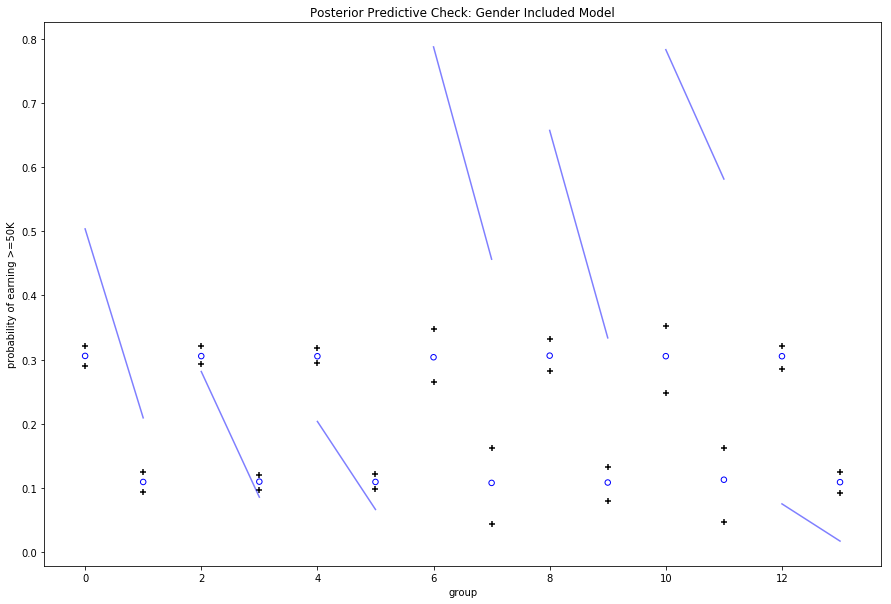

In [17]:
hpdgen = pm.hpd(ppcgen['gen'])
plt.figure(figsize=(15,10))
for i in range(0,13,2):
    y1 = maindf['above 50'][i]/maindf['total'][i]
    y2 = maindf['above 50'][i+1]/maindf['total'][i+1]
    plt.plot([i,i+1],[y1,y2],c='b',alpha=0.5)
plt.scatter(range(14),ppcgen['gen'].mean(axis=0)/maindf['total'].values,s=30,edgecolors='b',linewidths=1,facecolors='none')
plt.scatter(range(14),hpdgen[:,0]/maindf['total'],c='black',marker='+')
plt.scatter(range(14),hpdgen[:,1]/maindf['total'],c='black',marker='+')
plt.xlabel('group')
plt.ylabel('probability of earning >=50K')
plt.title('Posterior Predictive Check: Gender Included Model')

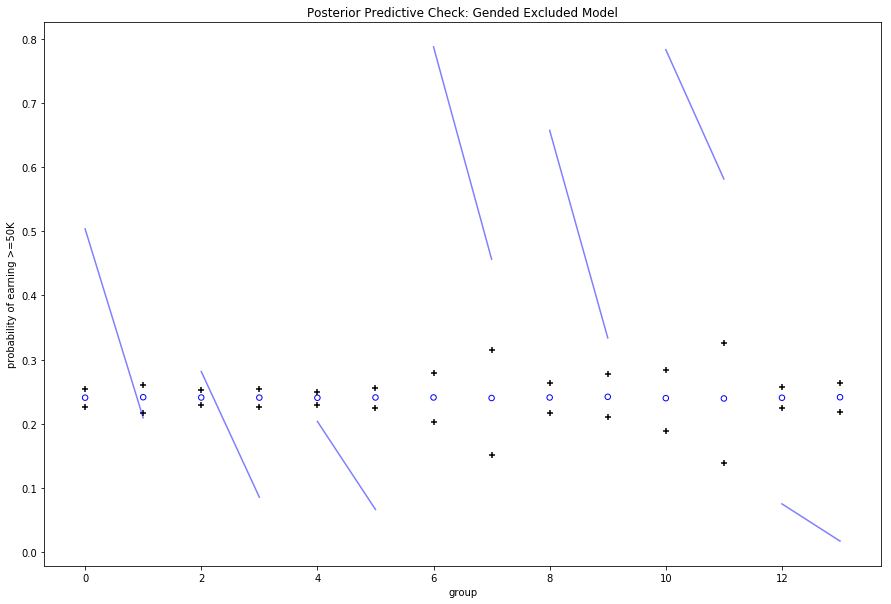

In [18]:
hpdgen = pm.hpd(ppcnogen['nogen'])
plt.figure(figsize=(15,10))
for i in range(0,13,2):
    y1 = maindf['above 50'][i]/maindf['total'][i]
    y2 = maindf['above 50'][i+1]/maindf['total'][i+1]
    plt.plot([i,i+1],[y1,y2],c='b',alpha=0.5)
plt.scatter(range(14),ppcnogen['nogen'].mean(axis=0)/maindf['total'].values,s=30,edgecolors='b',linewidths=1,facecolors='none')
plt.scatter(range(14),hpdgen[:,0]/maindf['total'],c='black',marker='+')
plt.scatter(range(14),hpdgen[:,1]/maindf['total'],c='black',marker='+')
plt.xlabel('group')
plt.ylabel('probability of earning >=50K')
plt.title('Posterior Predictive Check: Gended Excluded Model');

From our models it is clear that gender plays a signficant role in determining pay. We can see this in the plots as well as the fact that the gender inclusive model has a lower WAIC. The gender inclusive model  suggests women should have  20 percent lower pay on average across all education levels.However, we see that this is not the case across all our groups and we need a model to account for that.

Adding in the educational component

In [10]:
with pm.Model() as dept:
    dept_actor = pm.Normal('dept_actor', 0., 10., shape=7)
    logitpi =  dept_actor[maindf.index//2]
    dpt = pm.Binomial("dpt", p=pm.math.invlogit(logitpi),n=maindf['total'].values.tolist(),observed=maindf['above 50'].values)
    dpttrace = pm.sample(5000)

with pm.Model() as deptm:
    dept_actor = pm.Normal('dept_actor', 0., 10., shape=7)
    betam = pm.Normal("betam", 0, 10)
    logitpi =   dept_actor[maindf.index//2] + betam*mi.values
    dptm = pm.Binomial("dptm", p=pm.math.invlogit(logitpi),n=maindf['total'].values.tolist(),observed=maindf['above 50'].values)
    dptmtrace = pm.sample(5000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [dept_actor]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betam, dept_actor]


In [15]:
names=['gender', 'nogender','education','education+gender']
dfc=make_compare(names, [gentrace,nogentrace,dpttrace,dptmtrace],[gender,nogender,dept,deptm])
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
education+gender,117.57,5.28,0,1,5.89,0,1
education,2768.78,679.68,2651.21,0,685.67,682.5,1
gender,4946.77,482.76,4829.2,0,1190.08,1188.64,1
nogender,6492.71,411.49,6375.14,0,1600.42,1599.07,1


In [19]:
ppcdpt = pm.sample_ppc(dpttrace,500,model=dept)
ppcdptm = pm.sample_ppc(dptmtrace,500,model=deptm)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 615.38it/s]


Text(0.5,1,'Posterior Predictive Check: Education Included Model')

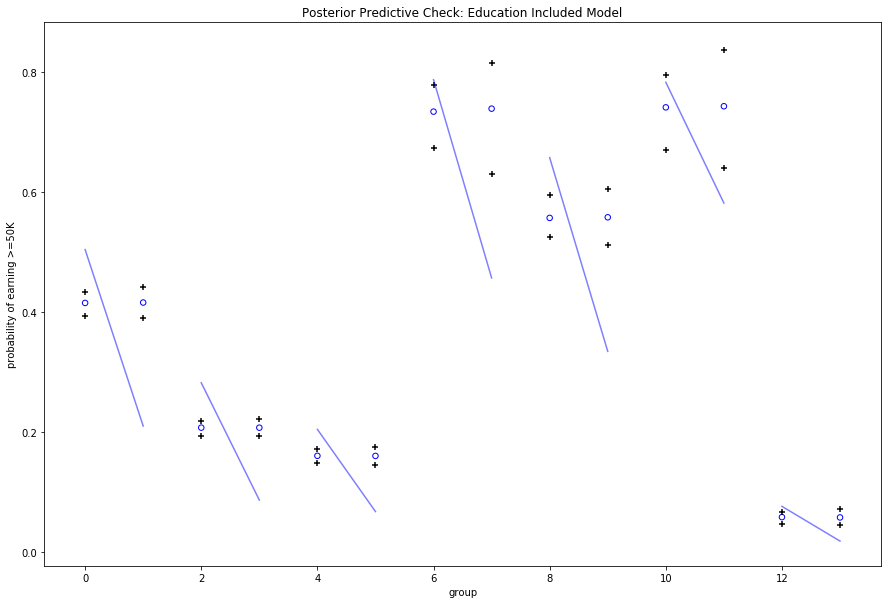

In [24]:
hpdgen = pm.hpd(ppcdpt['dpt'])
plt.figure(figsize=(15,10))
for i in range(0,13,2):
    y1 = maindf['above 50'][i]/maindf['total'][i]
    y2 = maindf['above 50'][i+1]/maindf['total'][i+1]
    plt.plot([i,i+1],[y1,y2],c='b',alpha=0.5)
plt.scatter(range(14),ppcdpt['dpt'].mean(axis=0)/maindf['total'].values,s=30,edgecolors='b',linewidths=1,facecolors='none')
plt.scatter(range(14),hpdgen[:,0]/maindf['total'],c='black',marker='+')
plt.scatter(range(14),hpdgen[:,1]/maindf['total'],c='black',marker='+')
plt.xlabel('group')
plt.ylabel('probability of earning >=50K')
plt.title('Posterior Predictive Check: Education Included Model')

Text(0.5,1,'Posterior Predictive Check: Gender + Education Included Model')

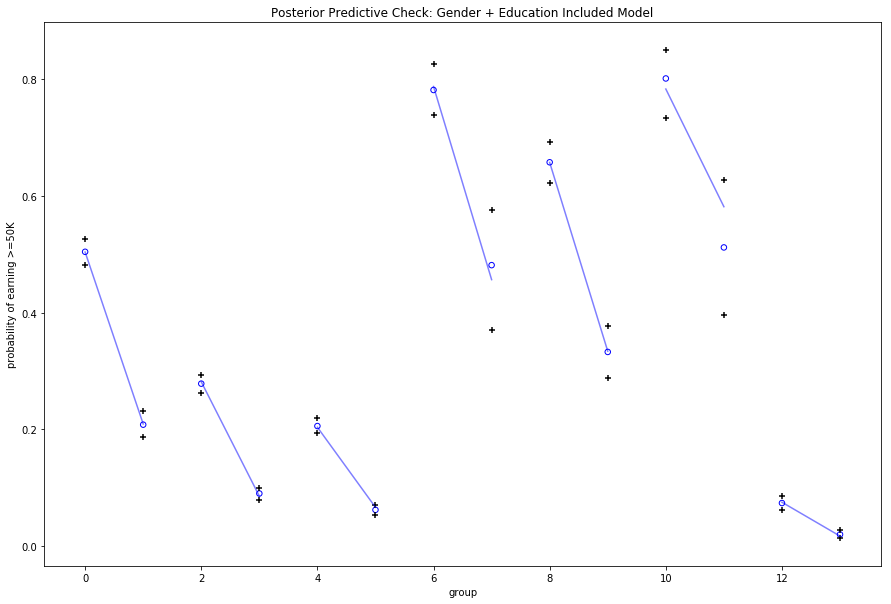

In [23]:
hpdgen = pm.hpd(ppcdptm['dptm'])
plt.figure(figsize=(15,10))
for i in range(0,13,2):
    y1 = maindf['above 50'][i]/maindf['total'][i]
    y2 = maindf['above 50'][i+1]/maindf['total'][i+1]
    plt.plot([i,i+1],[y1,y2],c='b',alpha=0.5)
plt.scatter(range(14),ppcdptm['dptm'].mean(axis=0)/maindf['total'].values,s=30,edgecolors='b',linewidths=1,facecolors='none')
plt.scatter(range(14),hpdgen[:,0]/maindf['total'],c='black',marker='+')
plt.scatter(range(14),hpdgen[:,1]/maindf['total'],c='black',marker='+')
plt.xlabel('group')
plt.ylabel('probability of earning >=50K')
plt.title('Posterior Predictive Check: Gender + Education Included Model')

We can see that the education model alone helps us get an average sense for income across the different education groups. In addition, by adding the gender component we are almost able to capture the trends perfectly which suggest quite strongly that pay classification strongly depends on a combination of gender and education level.